In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [2]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [3]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [7]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_second_neighbors(self, site):
        i, j = site

        # Primeros vecinos (ya definidos)
        first_neighbors = self.get_neighbors(site)

        # Conjunto para almacenar segundos vecinos
        second_neighbors = set()

        # Itera sobre cada primer vecino para obtener sus vecinos
        for neighbor in first_neighbors:
            neighbor_neighbors = self.get_neighbors(neighbor)
            for second_neighbor in neighbor_neighbors:
                # Evita añadir el sitio original y los primeros vecinos
                if second_neighbor != site and second_neighbor not in first_neighbors:
                    second_neighbors.add(second_neighbor)

        return list(second_neighbors)

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)


    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




In [9]:
class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []
        self.lattices = []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))
    
    def count_second_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_second_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        n_ij2 = self.count_second_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij + p.get("e_int_abs2", 0) * n_ij2
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij + p.get("e_int_des2", 0) * n_ij2
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            p = self.processes["diffusion"]
            E_diff = p["e_diff"] + p.get("e_int_diff", 0) * n_ij
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)



        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.lattices.append(self.lattice.lattice.copy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


{'adsorption': 5997, 'desorption': 144605}


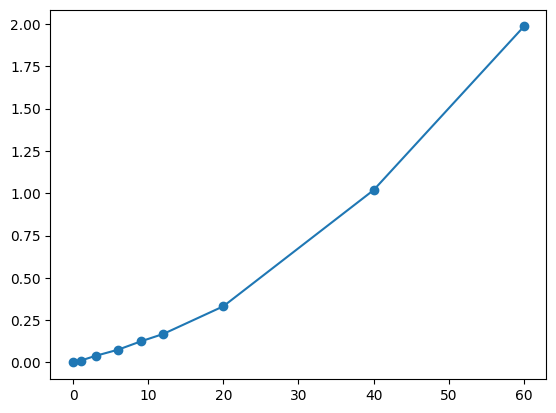

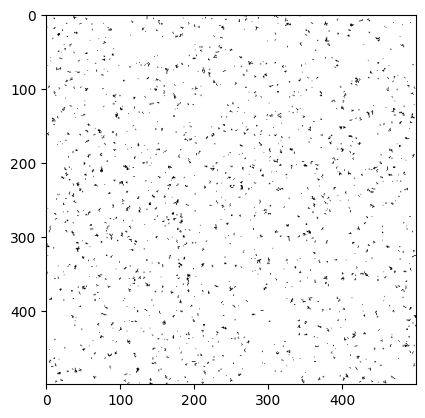

In [51]:

processes = {
    "adsorption": {"e_ads": 0.3, "e_int_abs": -0.6, "e_int_abs2": 0.15},
    "desorption": {"e_des": 0.184, "e_int_des": 0.3, "e_int_des2": -0.03},
}
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 500

# Elegí la red: Square o Hexagonal
lattice = HexagonalLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array, time_factor=1e-7)
occupancy = kmc.run_simulation()

simulated_data = occupancy.values()
print(kmc.events_count)
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.show()
plt.imshow(kmc.lattice.lattice, cmap='binary')